## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import random
import time
import json
import os

# Audio feature extraction
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import find_peaks

# for Kaggle CLI
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning models and utilities
# from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

# Deep learning for CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


In [2]:
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa")

## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [3]:
# uncomment if replicating project
# !pip install kaggle

In [4]:
# Load kaggle.json credentials
api_config_path = os.path.join(os.getcwd(), 'kaggle.json')
with open(api_config_path, 'r') as f:
    kaggle_config = json.load(f)

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Ensure the 'dataset' folder exists
dataset_dir = os.path.join(os.getcwd(), 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Use the Kaggle API to download the dataset
api.dataset_download_files('deepcontractor/musical-instrument-chord-classification',
                           path=dataset_dir, unzip=True)

print("Dataset downloaded and extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [5]:
# Define the base directory where the audio files are stored
base_dir = os.path.join(os.getcwd(), 'dataset', 'Audio_Files')

# Prepare to collect file details
file_details = []

# Loop through each category directory ('Major' and 'Minor')
for category in ['Major', 'Minor']:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            # Full path to file
            file_path = os.path.join(category_dir, filename)
            # Append the file path, filename (used as ID), and label to the list
            file_details.append({'path': file_path, 'id': filename, 'label': category})

# Save collected file details as a DataFrame
file_data = pd.DataFrame(file_details)

file_data.head()

,path,id,label
0,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_0.wav,Major
1,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_1.wav,Major
2,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_10.wav,Major
3,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_100.wav,Major
4,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_101.wav,Major


## Data Preparation

### Feature Extraction Functions:
- 

In [6]:
def extract_audio_features(signal=None, sr=22050, hop_length=512, n_fft=2048):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided.")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

    try:
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, hop_length=hop_length).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(signal, hop_length=hop_length).mean()

        return {
            'chroma': chroma,
            'mfcc': mfccs,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }

    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

In [7]:
def find_harmonics(signal=None, sr=22050, n_fft=2048):
    try:
        if signal is None or len(signal) == 0:
            raise ValueError("No audio signal provided.")

        S = np.abs(librosa.stft(signal, n_fft=n_fft))
        magnitude = np.mean(S, axis=1)
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)
        harmonic_frequencies = positive_freqs[peaks]
        harmonic_intervals = np.diff(harmonic_frequencies) if len(harmonic_frequencies) > 1 else []

        return harmonic_frequencies, harmonic_intervals

    except Exception as e:
        print(f"Error processing harmonics for augmented signal: {e}")
        return None, None

In [8]:
def extract_mel_spectrogram(signal=None, sr=22050, n_mels=128, hop_length=512, fixed_length=100):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided for mel-spectrogram extraction.")
        return np.full((fixed_length, n_mels), np.nan)

    try:
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, hop_length=hop_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        log_mel_spectrogram = log_mel_spectrogram.T

        if log_mel_spectrogram.shape[0] < fixed_length:
            pad_width = fixed_length - log_mel_spectrogram.shape[0]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:fixed_length, :]

        return log_mel_spectrogram

    except Exception as e:
        print(f"Error during Mel-spectrogram extraction: {e}")
        return np.full((fixed_length, n_mels), np.nan)

In [9]:
# Define a function to calculate harmonic ratios with feature toggle
def calculate_harmonic_ratios(df, harmonic_prefix='harmonic_', toggle=True):
    if not toggle:  # If toggle is False, skip harmonic ratio calculation
        return df

    harmonic_columns = [col for col in df.columns if harmonic_prefix in col]
    harmonic_ratios = []

    if len(harmonic_columns) > 1:
        for i in range(len(harmonic_columns)):
            for j in range(i + 1, len(harmonic_columns)):
                col_i = harmonic_columns[i]
                col_j = harmonic_columns[j]
                ratio_col_name = f'hratio_{i+1}_to_{j+1}'

                harmonic_ratio = df[col_i] / df[col_j]
                harmonic_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
                harmonic_ratios.append(harmonic_ratio.rename(ratio_col_name))

        ratio_df = pd.concat([df] + harmonic_ratios, axis=1)
        ratio_df.fillna(0, inplace=True)
        return ratio_df
    else:
        print("Not enough harmonic columns in data to compute ratios.")
        return df

In [10]:
def extract_audio_signal(path, sr=None):
    try:
        signal, sr = librosa.load(path, sr=sr)
        return signal, sr
    except Exception as e:
        print(f"Error loading audio from {path}: {e}")
        return None, None


In [11]:
def extract_harmonic_ratios_from_signal(signal, sr=22050, n_fft=2048):
    try:
        # Find harmonics using the previously defined find_harmonics function
        harmonic_frequencies, _ = find_harmonics(signal=signal, sr=sr, n_fft=n_fft)

        if harmonic_frequencies is None or len(harmonic_frequencies) < 2:
            return None  # Not enough harmonics to calculate ratios

        harmonic_ratios = {}
        base_freq = harmonic_frequencies[0]  # First harmonic as the base

        # Calculate ratios for each harmonic relative to the base harmonic
        for i, freq in enumerate(harmonic_frequencies[1:], start=2):
            ratio_key = f'ratio_{i}_to_1'
            harmonic_ratios[ratio_key] = freq / base_freq

        return harmonic_ratios

    except Exception as e:
        print(f"Error extracting harmonic ratios: {e}")
        return None

#### Running Feature Extraction on Origional Dataset

In [12]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip to next if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            # Extract features based on toggles
            if feature_toggles.get('chroma', False):
                chroma_features = extract_audio_features(signal, sr).get('chroma')
                if chroma_features is not None:
                    feature_dict['chroma'] = chroma_features
            
            if feature_toggles.get('mfcc', False):
                mfcc_features = extract_audio_features(signal, sr).get('mfcc')
                if mfcc_features is not None:
                    feature_dict['mfcc'] = mfcc_features

            if feature_toggles.get('spectral_centroid', False):
                spectral_centroid = extract_audio_features(signal, sr).get('spectral_centroid')
                feature_dict['spectral_centroid'] = spectral_centroid

            if feature_toggles.get('zero_crossing_rate', False):
                zero_crossing_rate = extract_audio_features(signal, sr).get('zero_crossing_rate')
                feature_dict['zero_crossing_rate'] = zero_crossing_rate

            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                if harmonics is not None:
                    feature_dict['harmonics'] = harmonics
                if intervals is not None:
                    feature_dict['intervals'] = intervals

            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                if mel_spectrogram is not None:
                    feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            # Extract harmonic ratios for major/minor classification
            if feature_toggles.get('harmonic_ratios', False):
                harmonic_ratios = extract_harmonic_ratios_from_signal(signal, sr)
                if harmonic_ratios:
                    feature_dict['harmonic_ratios'] = harmonic_ratios

            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [13]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='librosa')
warnings.filterwarnings("ignore", category=FutureWarning, module='librosa')


In [14]:
# Feature Toggles
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True,
    'harmonic_ratios': True 
}

# Extract Features for All Data
raw_features_df = extract_features_from_signals(file_data, feature_toggles)

# Display Resulting DataFrame
print("Extracted Features DataFrame:")
print(raw_features_df.head())

<ipython-input-10-eb235a571815>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=sr)


Error loading audio from C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame:
              id  Label                                       audio_signal  \
0    Major_0.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100.wav  Major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                                mfcc 

In [15]:
# Validation Step: Count Zero and Non-Zero Values for Raw Data
print("Validation of Feature Counts in raw_features_df:")

for column in raw_features_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(raw_features_df[column]):
        zero_count = (raw_features_df[column] == 0).sum()
        non_zero_count = (raw_features_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in raw_features_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

Validation of Feature Counts in raw_features_df:
Feature 'audio_signal':
  Zero Count: 6395195
  Non-Zero Count: 78320725

Feature 'mel_spectrogram':
  Zero Count: 571
  Non-Zero Count: 10981829



## Augmenting Data

We will augment the audio data using techniques such as time-stretching, pitch-shifting, and adding noise. The augmented data will then have features extracted in the same way as the original data. We will apply these augmentations to our data to create synthetic data - to even the distribution of our classes.

In [16]:
# Augmentation functions
def pitch_shift(signal, sr, n_steps=4):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def augment_audio(signal, sr):
    augmentations = ['time_stretch', 'pitch_shift', 'add_noise']
    augmentation = random.choice(augmentations)

    if augmentation == 'time_stretch':
        return librosa.effects.time_stretch(signal, rate=1.2)
    elif augmentation == 'pitch_shift':
        return pitch_shift(signal, sr, n_steps=4)
    elif augmentation == 'add_noise':
        return add_noise(signal)
    else:
        return signal

In [17]:
# Count existing samples in the original dataset
original_counts = file_data['label'].value_counts()
target_count = 500

# Determine how many samples to augment for each class
augmented_counts = {label: target_count - count if count < target_count else 0 for label, count in original_counts.items()}


In [18]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip to next if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            # Extract features based on toggles
            if feature_toggles.get('chroma', False):
                chroma_features = extract_audio_features(signal, sr).get('chroma')
                if chroma_features is not None:
                    feature_dict['chroma'] = chroma_features
            
            if feature_toggles.get('mfcc', False):
                mfcc_features = extract_audio_features(signal, sr).get('mfcc')
                if mfcc_features is not None:
                    feature_dict['mfcc'] = mfcc_features

            if feature_toggles.get('spectral_centroid', False):
                spectral_centroid = extract_audio_features(signal, sr).get('spectral_centroid')
                feature_dict['spectral_centroid'] = spectral_centroid

            if feature_toggles.get('zero_crossing_rate', False):
                zero_crossing_rate = extract_audio_features(signal, sr).get('zero_crossing_rate')
                feature_dict['zero_crossing_rate'] = zero_crossing_rate

            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                if harmonics is not None:
                    feature_dict['harmonics'] = harmonics
                if intervals is not None:
                    feature_dict['intervals'] = intervals

            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                if mel_spectrogram is not None:
                    feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            # Extract harmonic ratios for major/minor classification
            if feature_toggles.get('harmonic_ratios', False):
                harmonic_ratios = extract_harmonic_ratios_from_signal(signal, sr)
                if harmonic_ratios:
                    feature_dict['harmonic_ratios'] = harmonic_ratios

            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [19]:
# Feature Toggles for Augmented Data
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True,
    'harmonic_ratios': True
}

# Extract Features for Augmented Data
augmented_features_df = extract_features_from_signals(file_data, feature_toggles)

# Replace NaN values with 0 in augmented_features_df
augmented_features_df.fillna(0, inplace=True)

# Display Resulting DataFrame
print("Extracted Features DataFrame (Augmented Data):")
print(augmented_features_df.head())

<ipython-input-10-eb235a571815>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=sr)


Error loading audio from C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame (Augmented Data):
              id  Label                                       audio_signal  \
0    Major_0.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100.wav  Major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                    

In [20]:
# Validation Step: Count Zero and Non-Zero Values for Augmented Data
print("Validation of Feature Counts in augmented_features_df:")

for column in augmented_features_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(augmented_features_df[column]):
        zero_count = (augmented_features_df[column] == 0).sum()
        non_zero_count = (augmented_features_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in augmented_features_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

Validation of Feature Counts in augmented_features_df:
Feature 'audio_signal':
  Zero Count: 6395195
  Non-Zero Count: 78320725

Feature 'mel_spectrogram':
  Zero Count: 571
  Non-Zero Count: 10981829



In [22]:
# Verification Code

# Check if the DataFrame contains expected feature columns
expected_columns = [
    'id', 'Label', 'audio_signal', 'chroma', 'mfcc', 'spectral_centroid',
    'zero_crossing_rate', 'harmonics', 'intervals', 'mel_spectrogram', 'harmonic_ratios'
]
missing_columns = [col for col in expected_columns if col not in augmented_features_df.columns]
if not missing_columns:
    print("All expected columns are present.")
else:
    print(f"Missing columns: {missing_columns}")

# Check for missing values in key columns
print("\nChecking for missing values in important columns:")
for col in expected_columns:
    if col in augmented_features_df.columns:
        missing_count = augmented_features_df[col].isna().sum()
        print(f"{col}: {missing_count} missing values")

# Display the first few rows of the DataFrame to verify feature extraction
print("\nFirst few rows of the extracted features DataFrame:")
print(augmented_features_df.head())

# Check unique counts in key features to verify consistency
print("\nUnique value counts for key features:")
for col in ['Label', 'chroma', 'mfcc', 'harmonics']:
    if col in augmented_features_df.columns:
        # Apply a method to hash the lists/arrays, such as converting them to tuples
        unique_count = augmented_features_df[col].apply(lambda x: len(set(tuple(x))) if isinstance(x, (list, np.ndarray)) else x).nunique()
        print(f"{col}: {unique_count} unique values")

# Check if harmonic_ratios column contains valid data
if 'harmonic_ratios' in augmented_features_df.columns:
    print("\nChecking the content of 'harmonic_ratios' column:")
    
    # Extract keys from the harmonic_ratios dictionaries and check their counts
    all_keys = augmented_features_df['harmonic_ratios'].dropna().apply(lambda x: list(x.keys()) if isinstance(x, dict) else []).tolist()
    flattened_keys = [key for sublist in all_keys for key in sublist]
    unique_keys = set(flattened_keys)

    if unique_keys:
        print(f"Harmonic ratio keys found: {unique_keys}")
    else:
        print("No harmonic ratio keys detected.")

    # Optionally, count the number of unique values for each harmonic ratio key
    for key in unique_keys:
        unique_values = augmented_features_df['harmonic_ratios'].apply(lambda x: x[key] if isinstance(x, dict) and key in x else None).nunique()
        print(f"Unique values for {key}: {unique_values}")
else:
    print("\nNo 'harmonic_ratios' column detected.")


All expected columns are present.

Checking for missing values in important columns:
id: 0 missing values
Label: 0 missing values
audio_signal: 0 missing values
chroma: 0 missing values
mfcc: 0 missing values
spectral_centroid: 0 missing values
zero_crossing_rate: 0 missing values
harmonics: 0 missing values
intervals: 0 missing values
mel_spectrogram: 0 missing values
harmonic_ratios: 0 missing values

First few rows of the extracted features DataFrame:
              id  Label                                       audio_signal  \
0    Major_0.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100.wav  Major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0

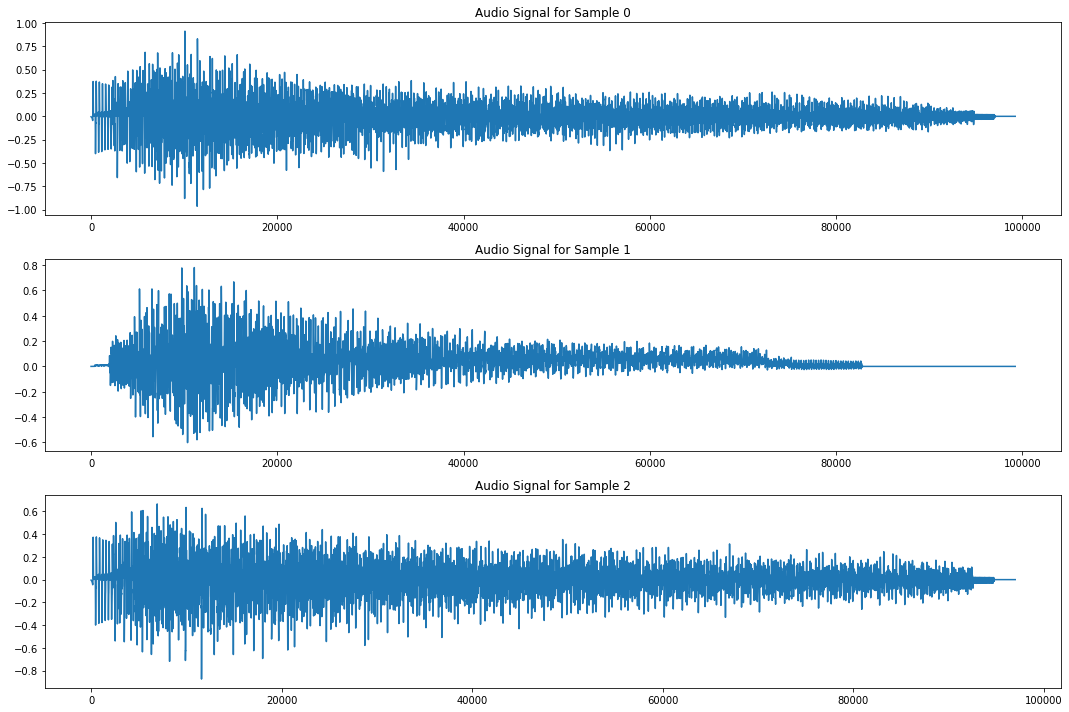

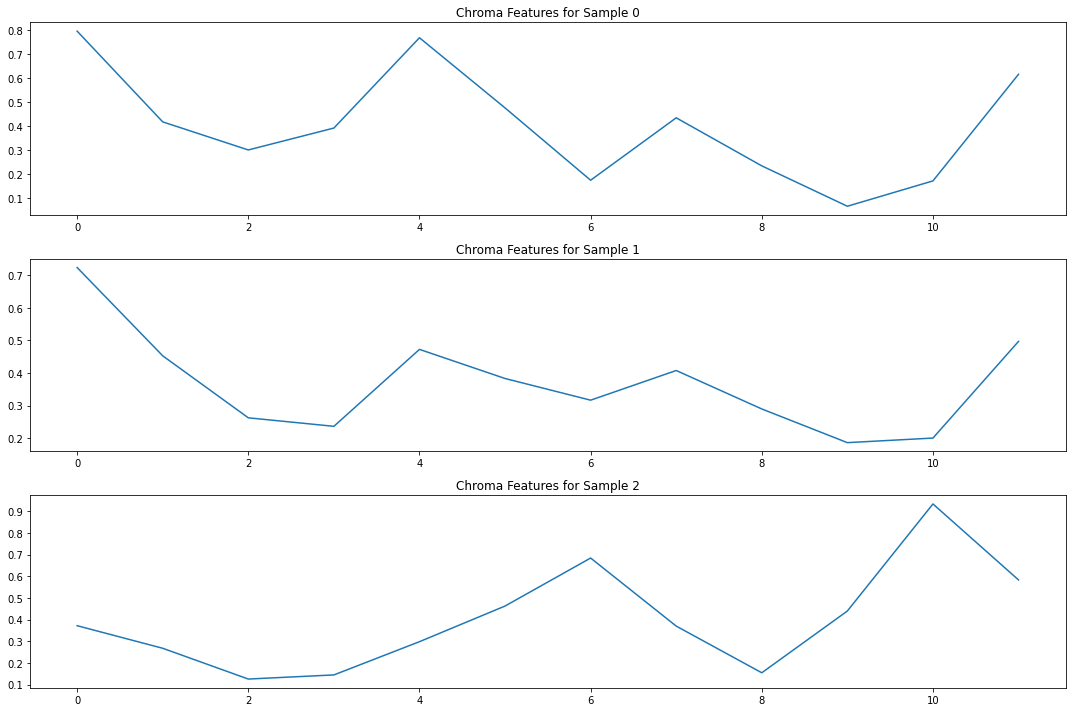

In [23]:
import matplotlib.pyplot as plt

# Plot a few audio signals to verify that they are different
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes):
    if i < len(augmented_features_df):
        audio_signal = augmented_features_df.loc[i, 'audio_signal']
        ax.plot(audio_signal)
        ax.set_title(f"Audio Signal for Sample {i}")
        
plt.tight_layout()
plt.show()

# Plot a few chroma features to verify variability
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes):
    if i < len(augmented_features_df):
        chroma = augmented_features_df.loc[i, 'chroma']
        ax.plot(chroma)
        ax.set_title(f"Chroma Features for Sample {i}")

plt.tight_layout()
plt.show()


## Making things better: Plan to Improve Binary Classification Model for Chord Identification

### 1. Data Leakage and Train-Test Split
- Ensure all feature extraction, scaling, and augmentations are only applied to training data, not validation/test data.
- Make sure train-test split occurs before any transformations or augmentations. Use stratified splitting to maintain balanced classes.

### 2. Feature Engineering
- Avoid overfitting to specific harmonics or intervals. Select those with general patterns across the dataset.
- Focus on musically relevant harmonic ratios (e.g., fundamental vs. third or fifth harmonics).
- Use statistical methods (e.g., mutual information, RFE) to select impactful features and reduce noisy/redundant ones.

### 3. Augmentation
- Use controlled augmentation to avoid introducing too much noise.
- Focus on augmentations like time-stretching or adding noise, as pitch-shifting may blur differences between major and minor chords.

### 4. Data Balancing
- Apply techniques like SMOTE for balancing features or mix augmented and original data proportionally to avoid bias.
- Ensure data balance is maintained across train, validation, and test sets.

### 5. Mel-Spectrograms and CNN + LSTM Combination
- Ensure consistent Mel-spectrogram input sizes by padding or truncating spectrograms.
- Experiment with CNN kernel sizes and pooling strategies to improve frequency and temporal feature extraction.

### 6. Model Selection and Evaluation
- If the model is underperforming for the minor class, use `class_weight` to handle imbalanced classes.
- Focus on metrics like F1-score, precision, or recall instead of accuracy to evaluate model performance.
- Use Batch Normalization, Dropout, and simpler LSTM models to avoid overfitting before moving to CNN + LSTM.

### 7. Alternative Feature Representations
- Prioritize features that emphasize differences in harmonic structure, such as the major vs. minor third intervals.
- Include delta MFCCs for temporal dynamics.
- Consider spectral peaks specifically associated with major or minor chord intervals.

### 8. Reducing Complexity and Model Testing
- Try simpler models like Random Forests and SVM before CNN + LSTM to see if they can distinguish between chords.
- Reduce dimensionality by removing highly correlated features or use PCA for variance retention.

### 9. Validation Strategy
- Use k-fold cross-validation to assess model generalizability and ensure the model isn't overfitting to specific data splits.


In [ ]:
for column in augmented_features_df.columns:
    print(column)